In [21]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .master("local[*]") \
    .getOrCreate()

# Test with a simple DataFrame
data = [("John", 30), ("Alice", 25), ("Bob", 35)]
df = spark.createDataFrame(data, ["Name", "Age"])
df.show()

+-----+---+
| Name|Age|
+-----+---+
| John| 30|
|Alice| 25|
|  Bob| 35|
+-----+---+



In [22]:
# import df_with_dow.csv/part-00000-2bd45c6f-2cf2-4333-81d8-96431e4c7041-c000.csv
df = spark.read.csv("df_with_dow.csv/part-00000-81cc640a-acde-44c7-bf1e-fdb9f666b20b-c000.csv", header=True, inferSchema=True)
df.show()

+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
|pickup_date|pickup_day_of_week|pickup_hour|dropoff_date|dropoff_day_of_week|dropoff_hour|passenger_count|trip_distance|RatecodeID|     pickup_location|    dropoff_location|total_amount|
+-----------+------------------+-----------+------------+-------------------+------------+---------------+-------------+----------+--------------------+--------------------+------------+
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|          2.0|         1|        Midtown East|        East Chelsea|        17.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|           Saturday|           0|              1|         1.53|         1|        Clinton East|Upper West Side S...|        12.3|
| 2019-06-01|          Saturday|          0|  2019-06-01|        

24/12/05 18:38:57 WARN CacheManager: Asked to cache already cached data.


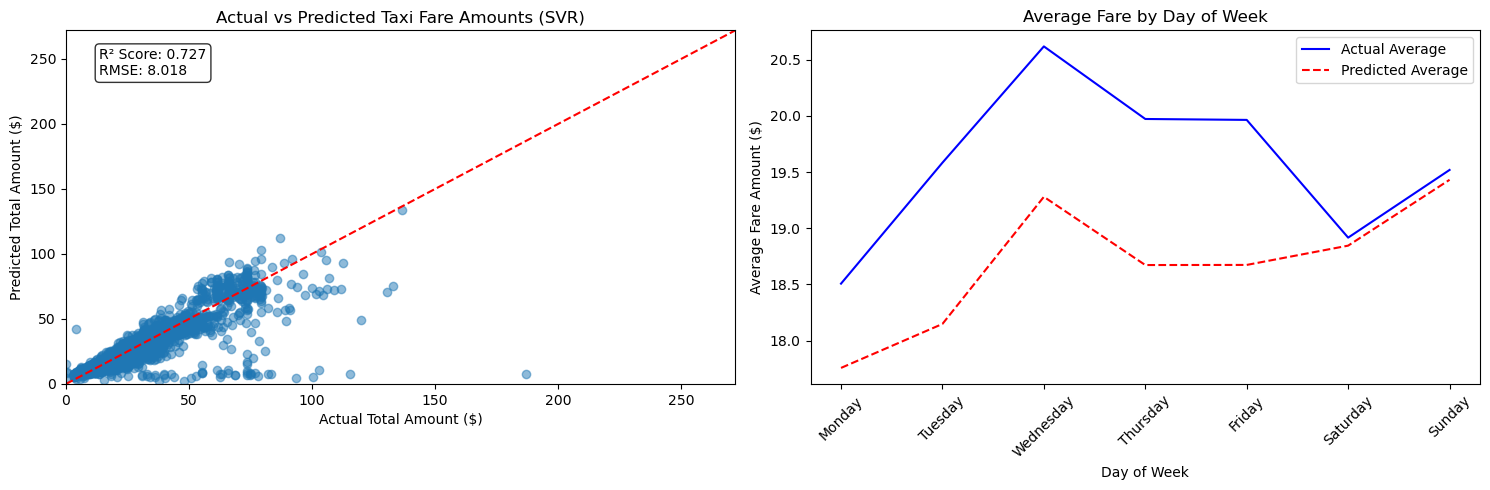


Feature Importances (SVR Coefficients):
trip_distance: 13.8550
dropoff_location_idx: 0.7142
pickup_hour: 0.3312
pickup_location_idx: 0.2856
day_sin: 0.2054
day_cos: 0.0341
passenger_count: 0.0007


In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import col, sin, cos, pandas_udf
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Sample 10% of the data and cache it
df = df.sample(fraction=0.1, seed=42).cache()

# Drop existing indexed columns if they exist
columns_to_drop = ["day_number", "day_sin", "day_cos", 
                  "pickup_location_idx", "dropoff_location_idx"]
for col_name in columns_to_drop:
    if col_name in df.columns:
        df = df.drop(col_name)

# Create temporal features
# Convert day of week to numeric and create cyclic features
day_indexer = StringIndexer(inputCol="pickup_day_of_week", outputCol="day_number")
df = day_indexer.fit(df).transform(df)

# Create cyclic features for days (converts to continuous circular feature)
df = df.withColumn("day_sin", sin(col("day_number") * 2.0 * 3.14159 / 7.0))
df = df.withColumn("day_cos", cos(col("day_number") * 2.0 * 3.14159 / 7.0))

# Convert categorical location columns to numeric
location_indexer = StringIndexer(inputCol="pickup_location", outputCol="pickup_location_idx")
df = location_indexer.fit(df).transform(df)

dropoff_indexer = StringIndexer(inputCol="dropoff_location", outputCol="dropoff_location_idx")
df = dropoff_indexer.fit(df).transform(df)

# Feature assembly with temporal features
assembler = VectorAssembler(
    inputCols=["pickup_hour", "day_sin", "day_cos", 
               "passenger_count", "trip_distance", 
               "pickup_location_idx", "dropoff_location_idx"],
    outputCol="features",
    handleInvalid="skip"
)
data = assembler.transform(df).cache()

# Train SVR model with smaller batch
train_sample = data.limit(10000)
features_rdd = train_sample.select("features").rdd.map(lambda row: row[0].toArray())
X = np.array(features_rdd.collect())
y = np.array(train_sample.select("total_amount").collect()).ravel()

# Create and train SVR model
svr = SVR(kernel='linear', C=1.0, cache_size=1000)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
svr.fit(X_scaled, y)

# Prediction UDF with error handling
@pandas_udf(DoubleType())
def svr_predict(features):
    try:
        X = np.vstack([np.fromstring(f[1:-1], sep=',') for f in features])
        X_scaled = scaler.transform(X)
        return pd.Series(svr.predict(X_scaled))
    except Exception as e:
        print(f"Error in prediction: {e}")
        return pd.Series([None] * len(features))

# Transform data and add predictions
data = assembler.transform(df)
data = data.withColumn("features_str", col("features").cast("string"))
predictions = data.withColumn("prediction", svr_predict(col("features_str")))

# Calculate metrics
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction")
r2 = evaluator.setMetricName("r2").evaluate(predictions)
rmse = evaluator.setMetricName("rmse").evaluate(predictions)

# Create visualizations
plt.figure(figsize=(15, 5))

# 1. Actual vs Predicted Plot
plt.subplot(1, 2, 1)
pred_pd = predictions.select("total_amount", "prediction").toPandas()

max_value = max(pred_pd["total_amount"].max(), pred_pd["prediction"].max())
axis_limit = 0.8 * max_value

plt.scatter(pred_pd["total_amount"], pred_pd["prediction"], alpha=0.5)
plt.plot([0, axis_limit], [0, axis_limit], 'r--')
plt.xlim(0, axis_limit)
plt.ylim(0, axis_limit)

plt.xlabel("Actual Total Amount ($)")
plt.ylabel("Predicted Total Amount ($)")
plt.title("Actual vs Predicted Taxi Fare Amounts (SVR)")

metrics_text = f'R² Score: {r2:.3f}\nRMSE: {rmse:.3f}'
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Average Fare by Day of Week
plt.subplot(1, 2, 2)
day_avg = predictions.groupBy("pickup_day_of_week").agg(
    {"total_amount": "avg", "prediction": "avg"}
).toPandas()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = day_avg.set_index('pickup_day_of_week').reindex(days_order)

plt.plot(day_avg.index, day_avg['avg(total_amount)'], 'b-', label='Actual Average')
plt.plot(day_avg.index, day_avg['avg(prediction)'], 'r--', label='Predicted Average')
plt.xticks(rotation=45)
plt.xlabel("Day of Week")
plt.ylabel("Average Fare Amount ($)")
plt.title("Average Fare by Day of Week")
plt.legend()

plt.tight_layout()
plt.show()

# Feature importances
if hasattr(svr, 'coef_'):
    feature_names = ["pickup_hour", "day_sin", "day_cos", 
                    "passenger_count", "trip_distance", 
                    "pickup_location_idx", "dropoff_location_idx"]
    importances = [(feature, abs(coef)) for feature, coef in zip(feature_names, svr.coef_[0])]
    importances.sort(key=lambda x: x[1], reverse=True)
    print("\nFeature Importances (SVR Coefficients):")
    for feature, importance in importances:
        print(f"{feature}: {importance:.4f}")